In [21]:
import pandas as pd
from models import AR_Net, AR, AR_Net_multi, AR_multi


import matplotlib.pyplot as plt

df = pd.read_csv('data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
Period,,,,,,,,
2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
## Add info on day and hour
def add_covariates(dataf):
    dataf['Period'] = dataf.index.values
    dataf['Day'] = dataf['Period'].dt.dayofweek
    dataf['Hour'] = dataf['Period'].dt.hour

    ## shift to have info of day and hour at time t (and not t-1 as for sessions) when predicting t
    dataf['Day'] = dataf['Day'].shift(-1, fill_value = 6)
    dataf['Hour'] = dataf['Hour'].shift(-1, fill_value = 14)

    dataf = dataf.drop(columns = ['Period'])

    return dataf

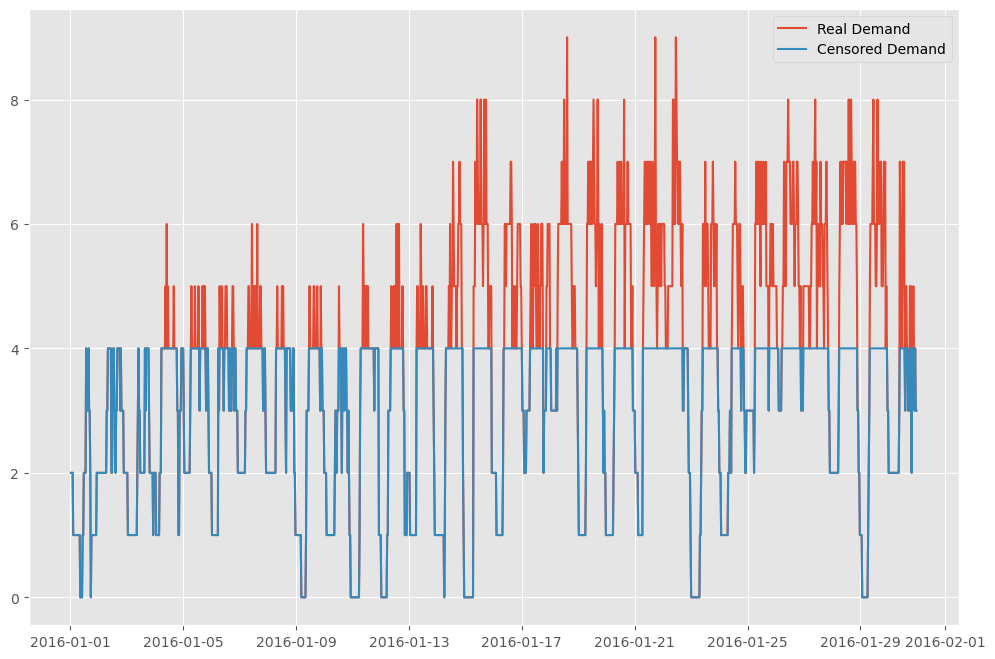

In [23]:
df = add_covariates(df)
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
df_sample = add_covariates(df)
#df_sample = df.WEBSTER[((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()

df_sample = df[['WEBSTER','Day', 'Hour']][((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()
df_sample = df_sample.rename(columns = {'WEBSTER': 'Sessions'}).reset_index()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4
df_sample.reset_index(drop=True, inplace=True)
plt.plot(df_sample.Period, df_sample.Sessions, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored, label='Censored Demand')
plt.legend()
plt.show()

In [24]:
import torch.nn as nn
import torch
import numpy as np


In [25]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

In [26]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)
    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    # Calculate MSE and report it
    mse = nn.functional.mse_loss(y_predict, y)

    return mse.data.item()


In [27]:
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))

In [28]:
def train_predict_ar(model, optimizer, loss_fn, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        loss_sum = 0
        for i in range((len(df_sample)-input_dim)//output_dim):
            X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i].Sessions.values, dtype=torch.float32).view(1, -1)
            y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
            loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
        losses.append(loss_sum/epochs)
        if (epoch % 50 == 0 ):
            print(f'Epoch: {epoch} Loss: {np.mean(losses)}')

    PREDICT_DAYS = 22
    periods = []
    predictions = []

    model.eval()
    for days in range(PREDICT_DAYS):
        # make prediction
        X = df_sample.reset_index(drop=True).iloc[output_dim*days: input_dim + output_dim * days]
        y = df_sample.reset_index(drop=True).iloc[output_dim*days + input_dim: output_dim*(1+days) + input_dim]
        y_predict = model.forward(torch.tensor(X.Sessions.values, dtype=torch.float32).view(1, -1))
        y_predict = y_predict.detach().numpy().reshape(-1)
        predictions = predictions + list(y_predict)
        periods = periods + list(y.Period.values)

    return model, periods, predictions, losses

AR model created with input_dim:  336  and output_dim:  48
Epoch: 0 Loss: 5.458879875183105
Epoch: 50 Loss: 5.425130660057067
Epoch: 100 Loss: 4.282946179474934
Epoch: 150 Loss: 3.6030897251754403
Epoch: 200 Loss: 3.276403018019092


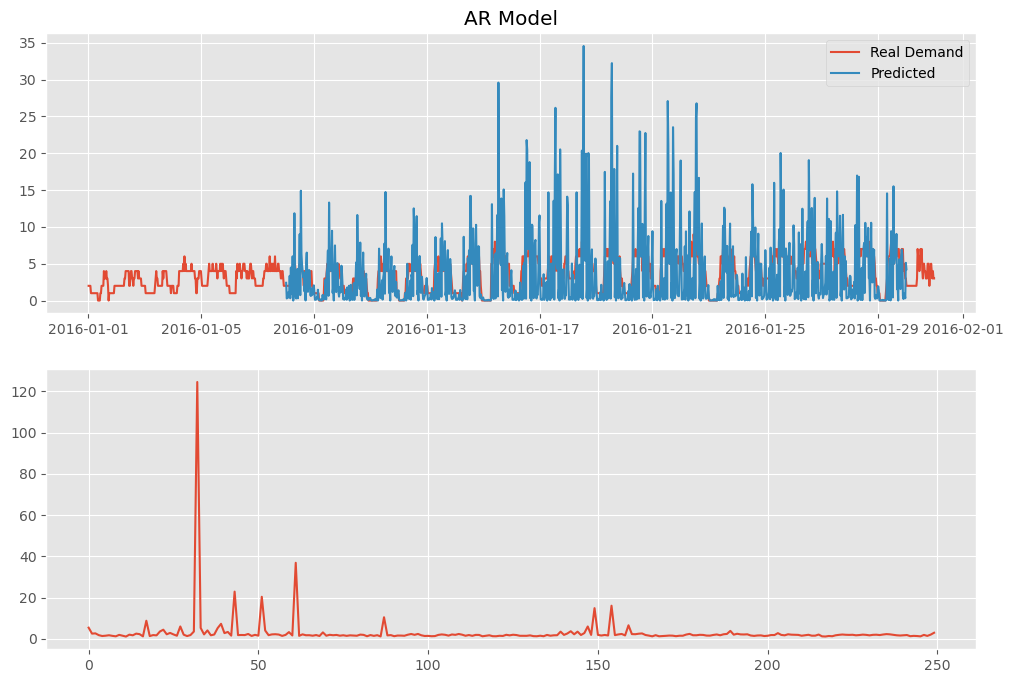

In [29]:
epochs = 250
model = AR(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.PoissonNLLLoss(log_input=False)#poisson_negative_log_likelihood

model, periods, predictions, losses = train_predict_ar(model, optimizer, loss_fn, epochs)

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
ax[0].plot(periods, predictions, label='Predicted')
ax[0].set_title('AR Model')
ax[0].legend()

ax[1].plot(losses)
plt.show()

Epoch: 0 Loss: 0.587497724533081
Epoch: 50 Loss: 0.22429612499592352
Epoch: 100 Loss: 0.1572224790324079
Epoch: 150 Loss: 0.13796541586143293
Epoch: 200 Loss: 0.12319100843051181


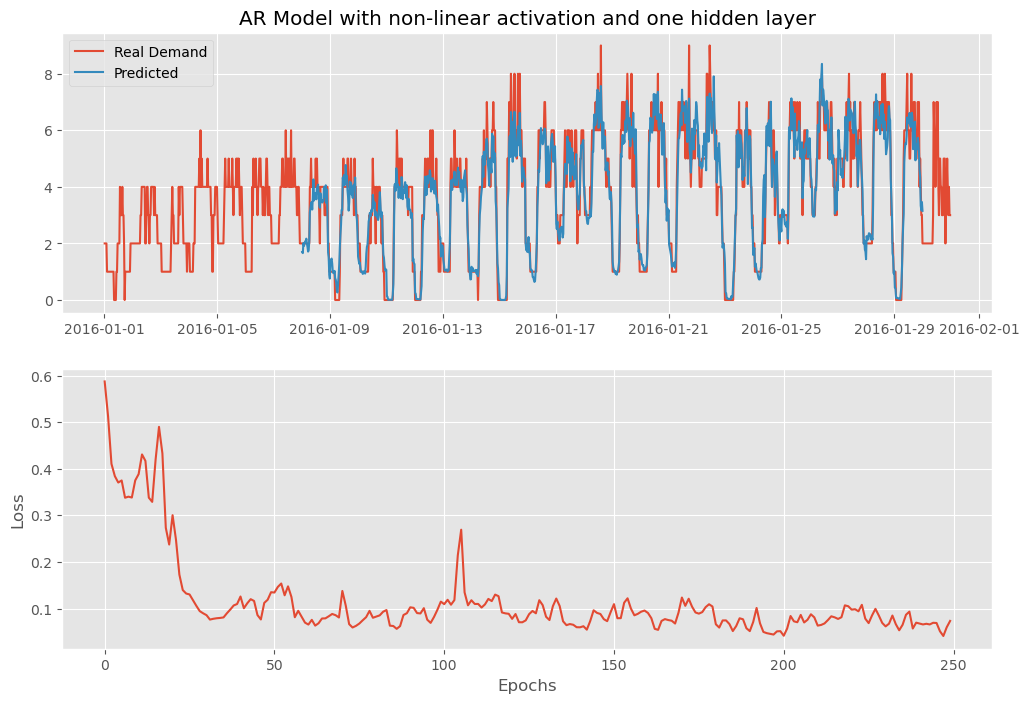

In [30]:
epochs = 250
model = AR_Net(input_dim, output_dim, 256)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.PoissonNLLLoss(log_input=False)#poisson_negative_log_likelihood
losses = []

model, periods, predictions, losses = train_predict_ar(model, optimizer, loss_fn, epochs)


fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
ax[0].plot(periods, predictions, label='Predicted')
ax[0].set_title('AR Model with non-linear activation and one hidden layer')
ax[0].legend()

ax[1].plot(losses)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

## Predicing using covariates (hour and week variable) at time t 

In [31]:
input_dim = 48*7

no_input_param = 3
output_dim = 48
hidden_dim = 100

In [32]:
df_sample.Sessions.values

array([2., 2., 2., ..., 4., 3., 3.])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_57901/3107346339.py:14: UserWarning: Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(y_predict, y)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please 

Epoch: 0 Loss: 4.818297995567322


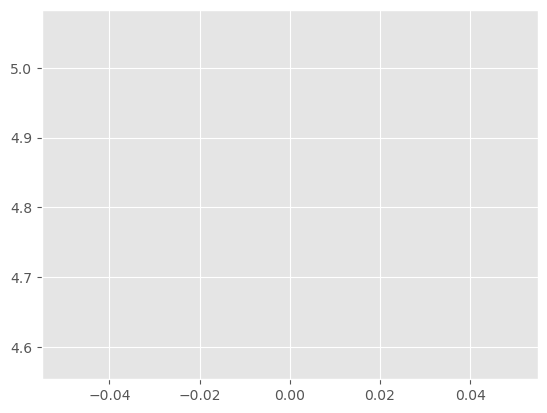

In [33]:
epochs = 250
model = AR_Net_multi(input_dim, output_dim, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
#loss_fn = poisson_negative_log_likelihood
loss_fn = nn.MSELoss()
losses = []
model.train()
for epoch in range(epochs):
    loss_sum = 0
    for i in range((len(df_sample)-input_dim)//output_dim):
        X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i][['Sessions','Day', 'Hour']].values, dtype=torch.float32).reshape((no_input_param,input_dim))
        y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
        loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
        
    losses.append(loss_sum/epochs)

    if (epoch % 50 == 0 ):
        print(f'Epoch: {epoch} Loss: {np.mean(losses)}')
    break
plt.plot(losses)
plt.show()

In [34]:
# make prediction
X_eval = df_sample.reset_index(drop=True).iloc[:input_dim]
y_eval = df_sample.reset_index(drop=True).iloc[input_dim:input_dim + output_dim]

model.eval()
y_predict = model.forward(torch.tensor(X_eval.Sessions.values, dtype=torch.float32).view(1, -1))
y_predict = y_predict.detach().numpy().reshape(-1)

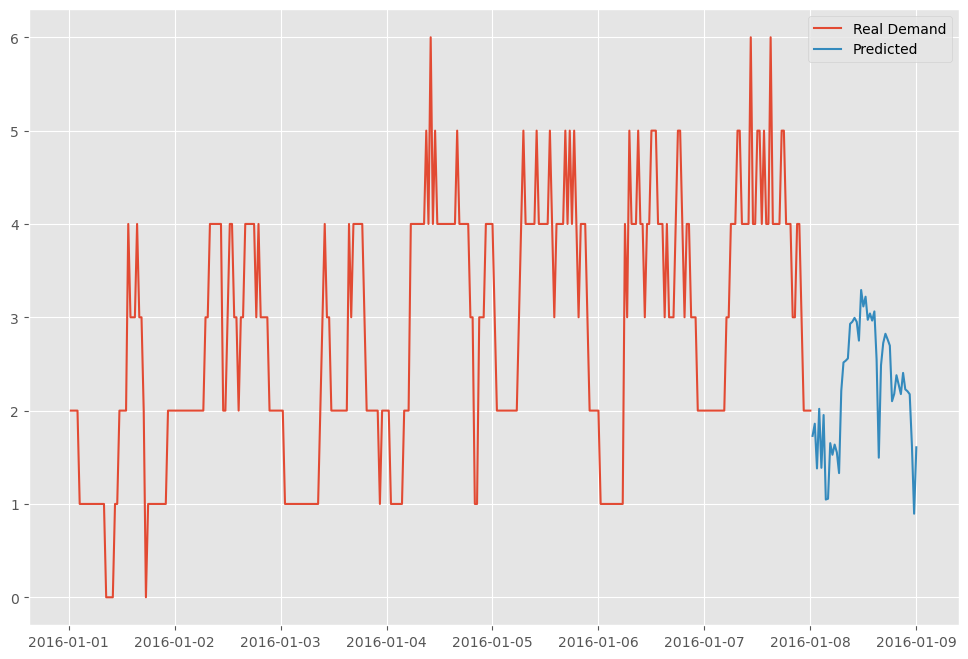

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_eval.Period, X_eval.Sessions.values, label='Real Demand')
#ax.plot(y_eval.Period, np.exp(y_predict), label='Predicted')
ax.plot(y_eval.Period, y_predict, label='Predicted')
plt.legend()

## LSTM multivariate

In [36]:
import torch.nn as nn
import torch
import numpy as np

import pandas as pd
from models import AR_Net
from models import AR_Net_multi

import matplotlib.pyplot as plt

def add_covariates(dataf):
    dataf['Period'] = dataf.index.values
    dataf['Day'] = dataf['Period'].dt.dayofweek
    dataf['Hour'] = dataf['Period'].dt.hour

    ## shift to have info of day and hour at time t (and not t-1 as for sessions) when predicting t
    dataf['Day'] = dataf['Day'].shift(-1, fill_value = 6)
    dataf['Hour'] = dataf['Hour'].shift(-1, fill_value = 14)

    dataf = dataf.drop(columns = ['Period'])

    return dataf

input_dim = 48*7
output_dim = 48
hidden_dim = 100


df = pd.read_csv('data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()
df = add_covariates(df)

In [37]:
##  Create target variable 
target_var = "WEBSTER"
features = [target_var, "Day", "Hour"]
#features = list(df.columns.difference(['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED']))

#features = list(df.columns.difference([target_var]))
forecast_lead = 24
target = f"{target_var}_lead{forecast_lead}"

df[target] = df[target_var].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [38]:
## Create train/test set
train_start = '2016-07-01'
test_start = '2016-07-31'
test_end = '2016-08-7'

df_train = df.loc[train_start:test_start].copy()
df_test = df.loc[test_start:test_end].copy()

print("Test set fraction:", len(df_test) / len(df_train))

Test set fraction: 0.25806451612903225


In [39]:
## Standardizing
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [40]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [41]:
### Creating data sets
torch.manual_seed(101)
from torch.utils.data import DataLoader

batch_size = 4
sequence_length = 72

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(X[1,11,:])
print(y[1])

Features shape: torch.Size([4, 72, 3])
Target shape: torch.Size([4])
tensor([ 0.8875, -0.5928,  0.6499])
tensor(1.3644)


In [54]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


## AR

In [56]:
model_ar = AR(input_dim, 1)
loss_function = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)
for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

AR model created with input_dim:  336  and output_dim:  1
Epoch 0
---------
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____


In [42]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        #out = self.activation(out)

        #return out.exp()
        print(out.shape)
        print("_____")
        return out

In [43]:
learning_rate = 5e-4
num_hidden_units = 16

def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))
    y_pred - y_true * log(y_pred)

def poisson(y_predict, y):
    """ https://github.com/keras-team/keras/blob/v2.11.0/keras/losses.py#L2404-L2437 """
    return torch.mean(y_predict - y * torch.log(y_predict)) ##-torch.sum(-y_predict + y*torch.log2(y_predict+1e-8))


model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
#loss_function = poisson
#loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4]

In [46]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean


torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size([4])
_____
torch.Size

In [47]:
df_out.min()

WEBSTER_lead24    0.000000
Model forecast    1.196515
dtype: float64

In [48]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"


plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

[]

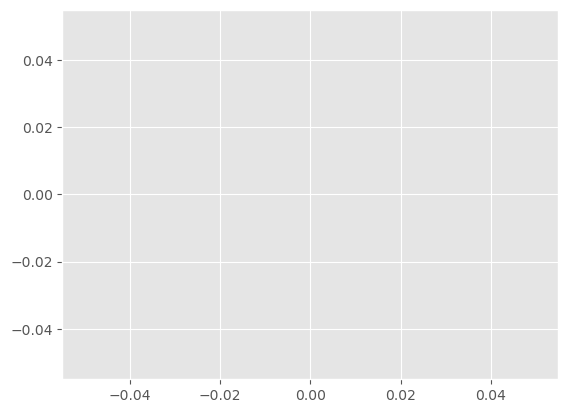

In [49]:
fig, ax = plt.subplots()
ax.plot()

## MISC

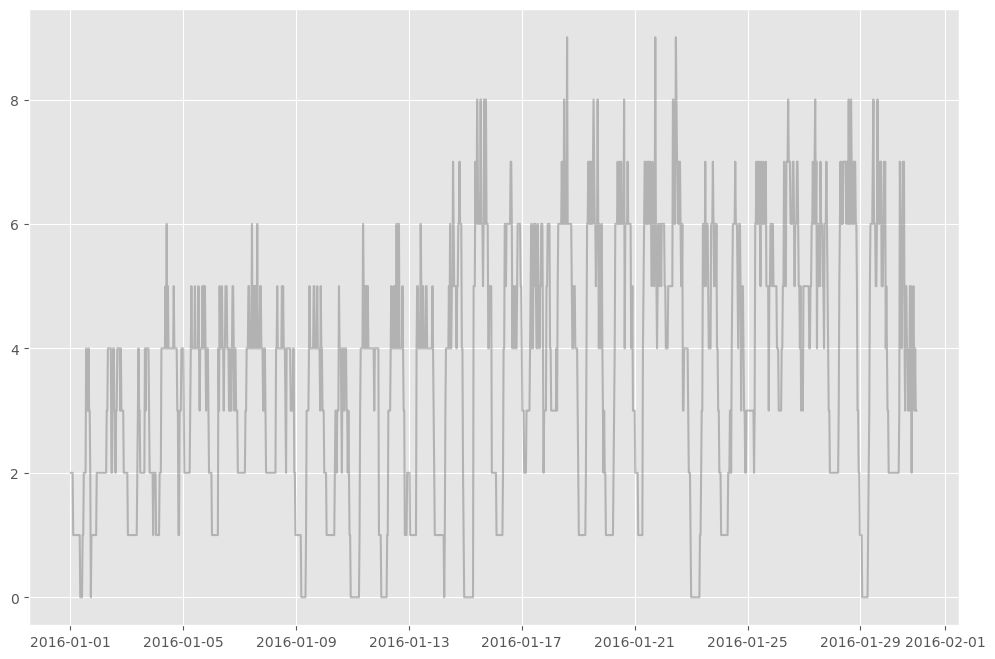

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [50]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()

In [51]:
# find the latest Period for each cluster


In [52]:
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-25 00:00:00' #need additional 7 days as given info (??)
test_end = '2014-09-07 23:00:00'
from dataloader import generate_covariates

covariates = generate_covariates(df[train_start:test_end].index, 4)
train_data = df[train_start:train_end].values
test_data = df[test_start:test_end].values

data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
total_time = df.shape[0] 
num_series = df.shape[1] 

ImportError: cannot import name 'generate_covariates' from 'dataloader' (/Users/carl/Documents/Matematisk Modellering/Speciale/dataloader.py)

In [ ]:
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset, Sampler

class TrainDataset(Dataset):
    def __init__(self, data_path, data_name):
        self.data = np.load(os.path.join(data_path, f'train_data_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'train_label_{data_name}.npy'))
        self.train_len = self.data.shape[0]

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]), self.label[index])

In [ ]:
nn.functional.poisson_nll_loss(torch.tensor([-100.0]), torch.tensor([500.0]), log_input=True, full=False)

tensor(50000.)